In [2]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import cartopy
import cartopy.crs as ccrs
from utils import constants as cnst
from eod import msg
from utils import u_grid, u_interpolate as u_int, u_darrays as uda, u_met
import glob
import metpy
from metpy import calc
from metpy.units import units
from scipy import stats
import metpy
from metpy import calc
from metpy.units import units
import pickle as pkl
import matplotlib.patches as patches

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [3]:
ml = 0.5
regions = {
'equatorial' : [(-5,0),(-78.25+ml, -73.75)],
'transition' : [(-8,-5), (-77.25+ml, -72.75)],
'central' : [(-12,-8), (-75.5+ml, -71.0)],
'southern' : [(-18,-15),  (-66.25+ml, -61.75)]}
h = 2000

In [4]:
topo_full = xr.open_dataset('/media/ck/Elements/SouthAmerica/ERA5/hourly/ERA5_static_hourly_0.25deg_peru.nc')
topo_full = uda.flip_lat(topo_full)

In [5]:
height = xr.open_dataset('/media/ck/Elements/SouthAmerica/ERA5/hourly/topo_ERA5_peru.nc')['h']


In [6]:
def read(region):
    
    alls = regions[region]
    hei = height.sel(latitude=slice(alls[0][0], alls[0][1])).mean('latitude').squeeze()
    topo = topo_full['z'].sel(latitude=slice(alls[0][0], alls[0][1])).mean('latitude').squeeze()
    inpath = '/media/ck/Elements/SouthAmerica/ERA5/hourly/'+region+'_cross_15UTC_1985-2018_peru_v2.nc'
    
    ds = xr.open_dataset(inpath)
    ds_filtered = ds.where(ds['z']>topo)
    
    return ds_filtered

In [7]:
def readERA(var):
    
    print('Opening', glob.glob('/media/ck/Elements/SouthAmerica/ERA5/hourly/'+var+'_15UTC_1981-*_peru_*.nc')[0])
    u200orig = xr.open_dataset(glob.glob('/media/ck/Elements/SouthAmerica/ERA5/hourly/'+var+'_15UTC_1981-*_peru_*.nc')[0])
    u200orig = uda.flip_lat(u200orig)
    datetimes = pd.to_datetime(u200orig.time.values)
    newtimes = []
    for t in datetimes:
        newtimes.append(t.replace(hour=0))
    u200orig['time'] = ('time', newtimes)
    return u200orig

In [8]:
mcs = xr.open_mfdataset('/media/ck/Elements/SouthAmerica/CHIRPS/SA_daily_onERA/CHIRPS_daily_onERA_*.nc')
tir = mcs['precip'].sel(time=((mcs['time.year']>=1985)&(mcs['time.year']<=2018))).sel(latitude=slice(-25,0), longitude=slice(-81,-58)).load()
tir = tir.where(height>2000)

In [9]:
tcwv = readERA('tcwv')['tcwv']

Opening /media/ck/Elements/SouthAmerica/ERA5/hourly/tcwv_15UTC_1981-2019_peru_big.nc


In [403]:
cape = readERA('cape')['cape']

Opening /media/ck/Elements/SouthAmerica/ERA5/hourly/cape_15UTC_1981-2019_peru_big.nc


In [405]:
region = 'central'

In [406]:
cross = read(region)

In [407]:
alls = regions[region]

In [408]:
cross = cross.sel(time=(cross['time.month']>=12) | (cross['time.month']<=3)).sel(longitude=slice(alls[1][0],alls[1][1])).mean('longitude')
tcw = tcw.sel(time=(tcw['time.month']>=12) | (tcw['time.month']<=3)).sel(longitude=slice(alls[1][0],alls[1][1]), latitude=slice(alls[0][0],alls[0][1])).mean(['latitude', 'longitude'])
tir = tir.sel(time=(tir['time.month']>=12) | (tir['time.month']<=3)).where(height>2000).sel(latitude=slice(alls[0][0],alls[0][1])).mean(['latitude', 'longitude'])

In [409]:
cape = cape.sel(longitude=slice(alls[1][0],alls[1][1]), latitude=slice(alls[0][0],alls[0][1])).mean(['latitude', 'longitude'])

In [410]:
pos = np.intersect1d(cross.time, tcw.time)
cross_cut = cross.sel(time=pos)

In [411]:
pos = np.intersect1d(cross_cut.time, tir.time)
cross_cut = cross_cut.sel(time=pos)
tcw_cut = tcw.sel(time=pos)
tir_cut = tir.sel(time=pos)
cape_cut = cape.sel(time=pos)

In [412]:

# allvars = []
# allp = []
# for var, lev in zip( ['u', 'v', 'q', 'w'], [200, 850, 850, 850,550]):
    
#     collect_r = []
#     collect_p = []    
#     for y in np.unique(cross_cut.time['time.year']):

#        # ipdb.set_trace()
#     #     cc = cross_cut.rolling(time=2, min_periods=2, center=True).mean().sel(time=str(y))
#     #     tt = tcw_cut.rolling(time=2, min_periods=2, center=True).mean().sel(time=str(y))
#     #     rr = tir_cut.rolling(time=2, min_periods=2, center=True).mean().sel(time=str(y))
#     #     ca = cape_cut.rolling(time=2, min_periods=2, center=True).mean().sel(time=str(y))

#         cc = cross_cut.sel(time=str(y))
#         rr = tir_cut.sel(time=str(y))

#         if var in ['q', 'v', 'w']: 
#             slope, inter, rval, pval, stderr = stats.linregress(cc[var].sel(level=slice(750,900)).mean('level').values, rr.values)    
            
#         else:
#             slope, inter, rval, pval, stderr = stats.linregress(cc[var].sel(level=lev).values, rr.values)

        
#         collect_r.append(rval)
#         collect_p.append(pval)
        

# #         if pval < 0.05:
# #             col = 'r'
# #         else:
# #             col = 'k'

# #         plt.scatter(y, rval, color=col)
    
#     allvars.append(np.array(collect_r))
#     allp.append(np.array(collect_p))

# tcwlist = []
# capelist = []
# tcwlistp = []
# capelistp = []
# ulistp = []
# ulist = []

# for y in np.unique(cross_cut.time['time.year']):
#             ca = cape_cut.sel(time=str(y))
#             tt = tcw_cut.sel(time=str(y))
#             rr = tir_cut.sel(time=str(y))
#             cc = cross_cut.sel(time=str(y))
            
#             wsv = cc['v'].sel(level=slice(600,700)).mean('level').values
#             wsu = cc['u'].sel(level=slice(600,700)).mean('level').values
#             ws = np.sqrt(wsv**2+wsu**2)
            
#             slope, inter, rval, pval, stderr = stats.linregress(tt.values, rr.values)
#             #slope, inter, crval, cpval, stderr = stats.linregress(ca.values, rr.values)
#             #slope, inter, urval, upval, stderr = stats.linregress(tt.values, cc['u'].sel(level=200).values)
#             #slope, inter, urval, upval, stderr = stats.linregress(rr.values, cc['q'].sel(level=slice(700,850)).mean('level').values) correlation between low level q and rain more stable recently
#             #slope, inter, urval, upval, stderr = stats.linregress(cc['w'].sel(level=slice(800,850)).mean('level').values, cc['q'].sel(level=slice(800,850)).mean('level').values)   # low level q and low level lift, strong negative daily correlation
            
#             slope, inter, urval, upval, stderr = stats.linregress(cc['u'].sel(level=200).values, tt)   #cc['q'].sel(level=slice(800,850)).mean('level').values
#             slope, inter, crval, cpval, stderr = stats.linregress(cc['q'].sel(level=slice(800,900)).mean('level').values, cc['w'].sel(level=slice(800,900)).mean('level').values) 
            
#            # ipdb.set_trace()
            
#             tcwlist.append(rval)
#             capelist.append(crval)
#             ulist.append(urval)
            
#             tcwlistp.append(pval)
#             capelistp.append(cpval)
#             ulistp.append(upval)
            
# allvars.append(np.array(tcwlist))
# allvars.append(np.array(capelist))
# allvars.append(np.array(ulist))

# allp.append(np.array(tcwlistp))
# allp.append(np.array(capelistp))
# allp.append(np.array(ulistp))


# # ADD JET WINDSPEED TO VARIABLES

In [10]:
def write_region(region, chirps, tcw):
    
    
    #tcw = readERA('tcwv')['tcwv']
    
    cross = read(region)
    alls = regions[region]
    
    cross_cut = cross.sel(time=(cross['time.month']>=12) | (cross['time.month']<=3)).sel(longitude=slice(alls[1][0],alls[1][1])).mean('longitude')
    tcw_cut = tcw.sel(time=(tcw['time.month']>=12) | (tcw['time.month']<=3)).sel(longitude=slice(alls[1][0],alls[1][1]), latitude=slice(alls[0][0],alls[0][1])).mean(['latitude', 'longitude'])
    tir_cut = tir.sel(time=(tir['time.month']>=12) | (tir['time.month']<=3)).where(height>2000).sel(latitude=slice(alls[0][0],alls[0][1])).mean(['latitude', 'longitude'])
    
    pos = np.intersect1d(cross_cut.time, tcw_cut.time)
    cross_cut = cross_cut.sel(time=pos)
    
    pos = np.intersect1d(cross_cut.time, tir_cut.time)
    cross_cut = cross_cut.sel(time=pos)
    tcw_cut = tcw_cut.sel(time=pos)
    tir_cut = tir_cut.sel(time=pos)
    
    allvars = []
    allp = []
    for var, lev in zip( ['u','q'], [200, 850]):

        collect_r = []
        collect_p = []    
        for y in np.unique(cross_cut.time['time.year']):

            cc = cross_cut.sel(time=str(y))
            rr = tir_cut.sel(time=str(y))

            cc = cross_cut.rolling(time=2, min_periods=2, center=True).mean().sel(time=str(y))
            rr = tir_cut.rolling(time=2, min_periods=2, center=True).mean().sel(time=str(y))


            if var in ['q', 'v', 'w']: 
                slope, inter, rval, pval, stderr = stats.linregress(cc[var].sel(level=slice(800,900)).mean('level').values, rr.values)    

            else:
                slope, inter, rval, pval, stderr = stats.linregress(cc[var].sel(level=lev).values, rr.values)


            collect_r.append(rval)
            collect_p.append(pval)


    #         if pval < 0.05:
    #             col = 'r'
    #         else:
    #             col = 'k'

    #         plt.scatter(y, rval, color=col)

        allvars.append(np.array(collect_r))
        allp.append(np.array(collect_p))

    tcwlist = []
    capelist = []
    tcwlistp = []
    capelistp = []
    ulistp = []
    ulist = []

    for y in np.unique(cross_cut.time['time.year']):
                tt = tcw_cut.sel(time=str(y))
                rr = tir_cut.sel(time=str(y))
                cc = cross_cut.sel(time=str(y))

                slope, inter, rval, pval, stderr = stats.linregress(tt.values, rr.values)
                slope, inter, crval, cpval, stderr = stats.linregress(cc['q'].sel(level=slice(800,900)).mean('level').values, cc['w'].sel(level=slice(800,900)).mean('level').values) 
                slope, inter, urval, upval, stderr = stats.linregress(cc['u'].sel(level=200).values, tt)   #cc['q'].sel(level=slice(800,850)).mean('level').values


               # ipdb.set_trace()

                tcwlist.append(rval)
                capelist.append(crval)
                ulist.append(urval)

                tcwlistp.append(pval)
                capelistp.append(cpval)
                ulistp.append(upval)

    allvars.append(np.array(tcwlist))
    allvars.append(np.array(capelist))
    allvars.append(np.array(ulist))

    allp.append(np.array(tcwlistp))
    allp.append(np.array(capelistp))
    allp.append(np.array(ulistp))
    
    varstack = np.vstack(allvars)
    pstack = np.vstack(allp)
    ipdb.set_trace()
    return varstack, pstack
    # ADD JET WINDSPEED TO VARIABLES

In [ ]:
eq_var, eq_p = write_region('equatorial', tir, tcwv)

> <ipython-input-10-58a20ddc1c1c>(95)write_region()
     94     ipdb.set_trace()
---> 95     return varstack, pstack
     96     # ADD JET WINDSPEED TO VARIABLES



In [12]:
trans_var, trans_p = write_region('transition', tir, tcwv)

In [13]:
cent_var, cent_p = write_region('central', tir, tcwv)

In [14]:
south_var, south_p = write_region('southern', tir, tcwv)

In [33]:
years = np.unique(tir.time['time.year'])

names = np.array(['u200/prcp', 'q850/prcp', 'tcw/prcp', 'q850/w850', 'u200/tcw'])#[::-1]

In [34]:
names

array(['u200/prcp', 'q850/prcp', 'tcw/prcp', 'q850/w850', 'u200/tcw'],
      dtype='<U9')

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  del sys.path[0]


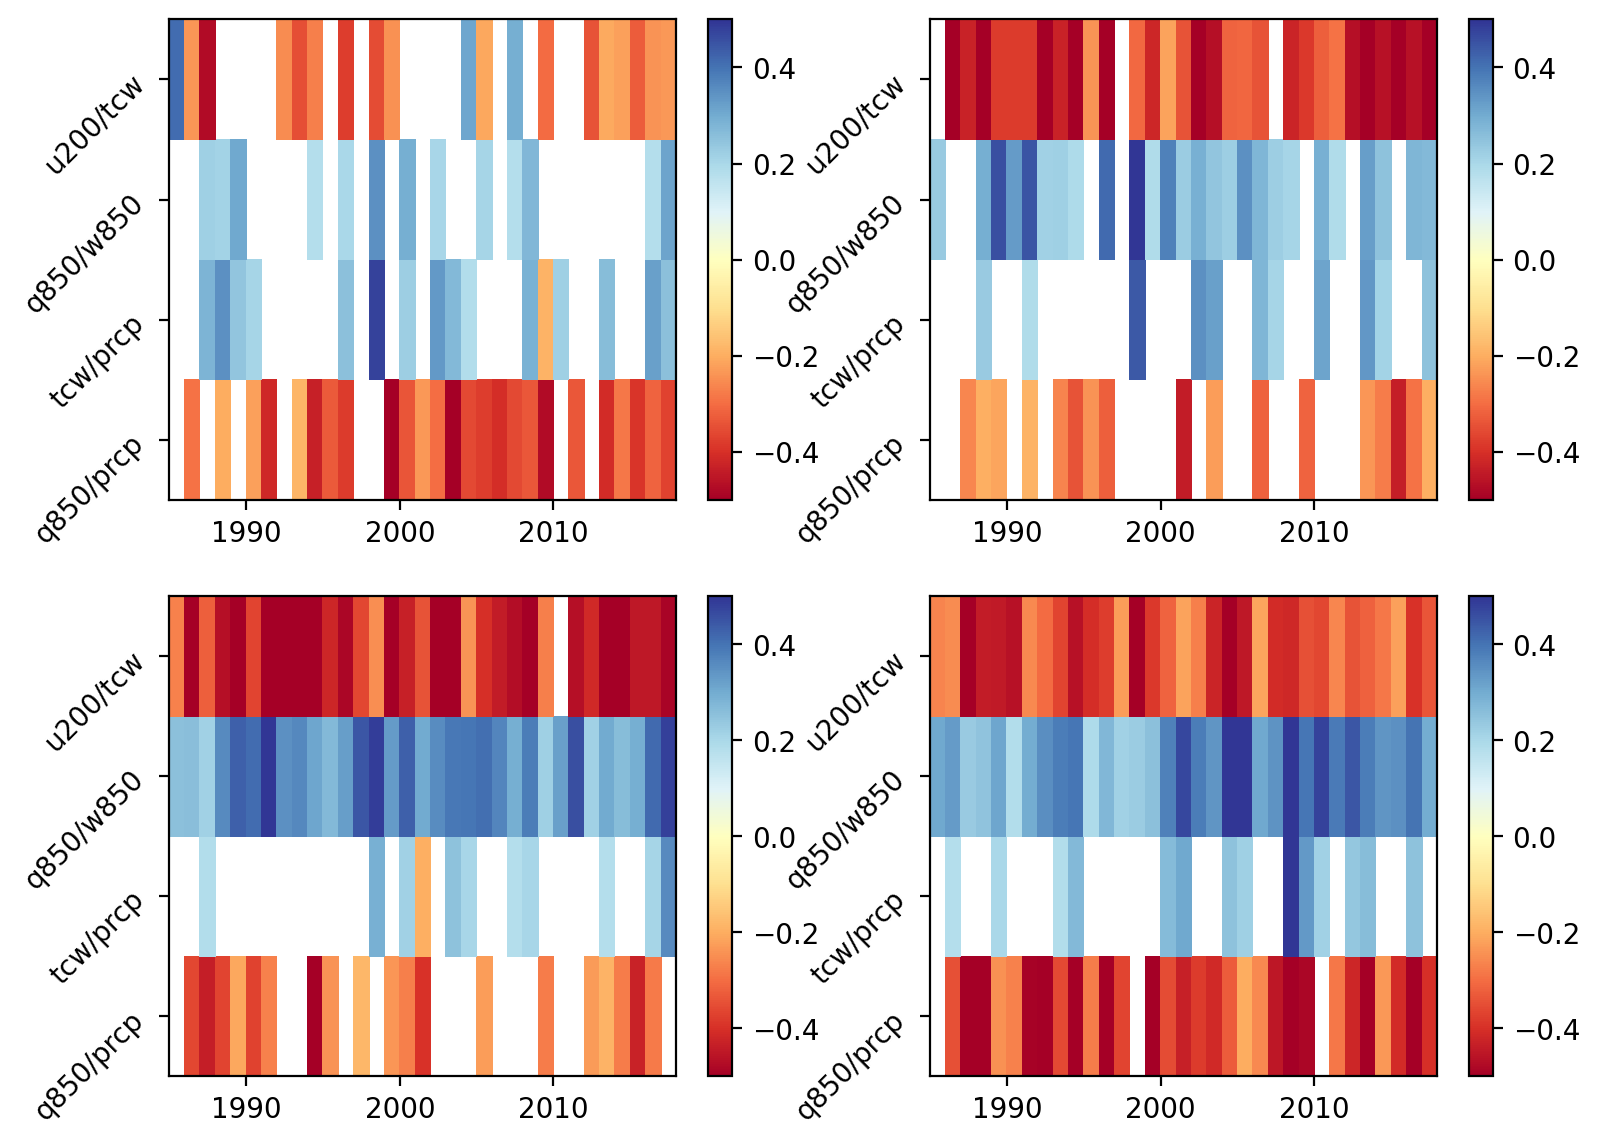

In [35]:
f = plt.figure(figsize=(9,7), dpi=200)
ids = 1
for dat, sig in zip([eq_var, trans_var, cent_var, south_var], [eq_p, trans_p, cent_p, south_p]):
    
    ax = f.add_subplot(2,2,ids)
    
    var_sig = dat.copy()
    var_sig[sig>0.05] = np.nan
    
    ax.set_yticks(np.arange(5)-0.5)
    ax.set_yticklabels(names, rotation=45)
    
    cbar =ax.pcolormesh(years, np.arange(len(names)), var_sig, vmin=-0.5, vmax=0.5, cmap='RdYlBu')
    plt.colorbar(cbar)
    
    ids+=1

In [420]:
varstack_sig = varstack.copy()
varstack_sig[pstack>0.05] = np.nan

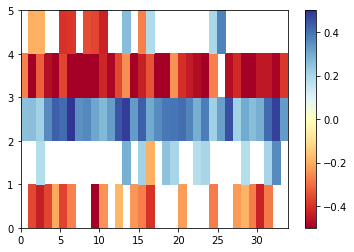

In [421]:
cbar = plt.pcolormesh(varstack_sig, vmin=-0.5, vmax=0.5, cmap='RdYlBu')
plt.colorbar(cbar)

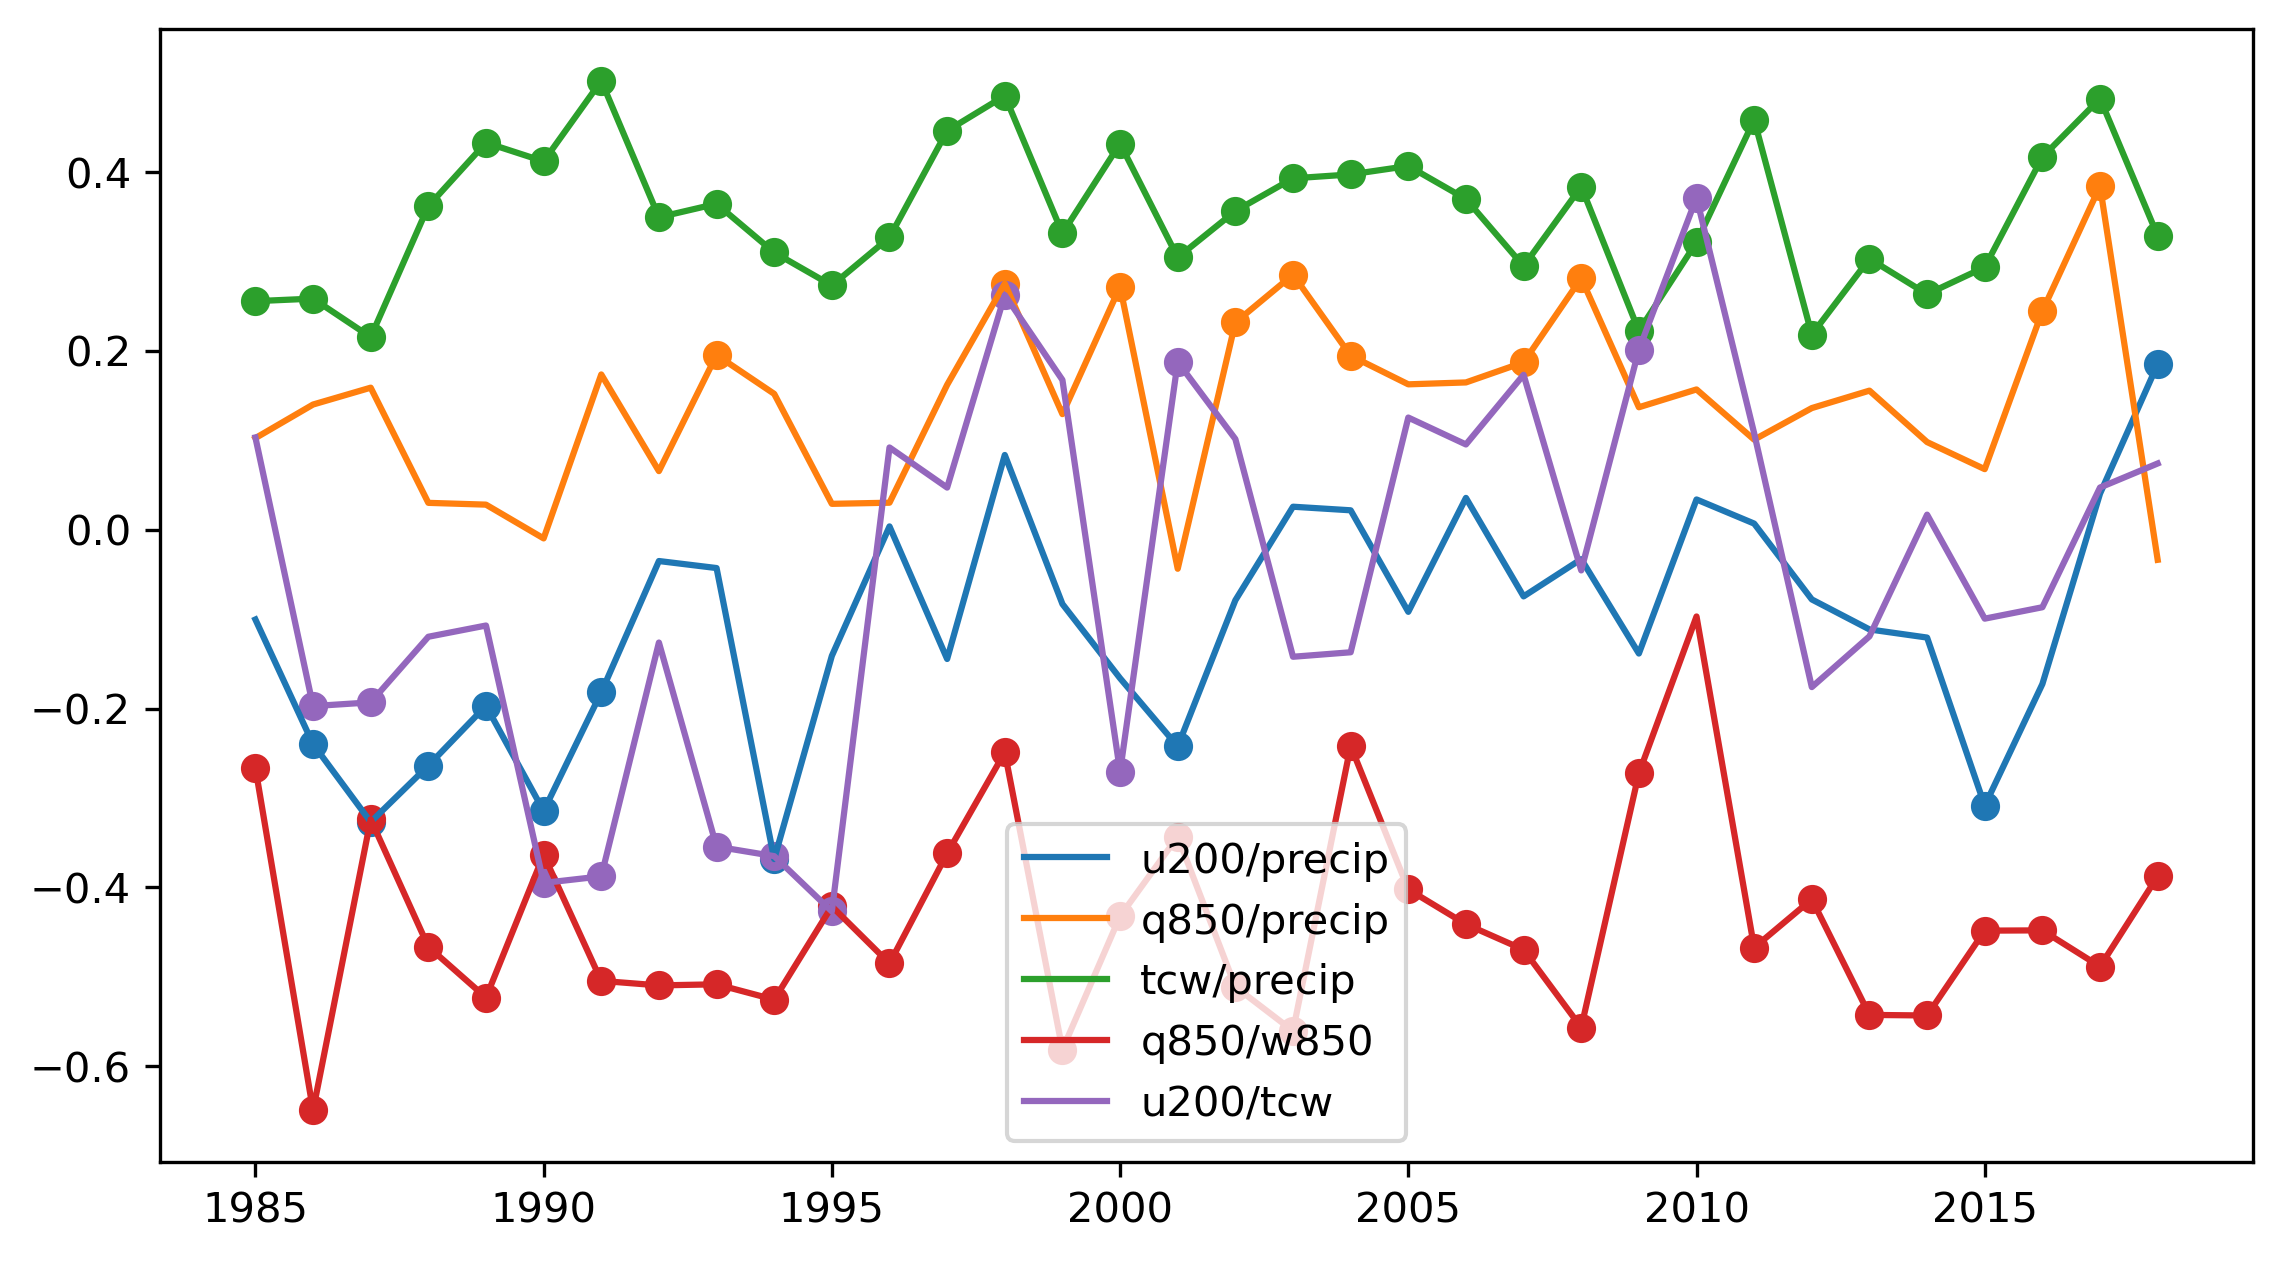

In [417]:
years = np.unique(cross_cut.time['time.year'])

f = plt.figure(figsize=(9,5), dpi=300)
for pp, vv, nn in zip(pstack, varstack, names):
    plt.plot(years, np.array(vv), label=nn)
    plt.scatter(years[pp<=0.05], np.array(vv[pp<=0.05]))
plt.legend()

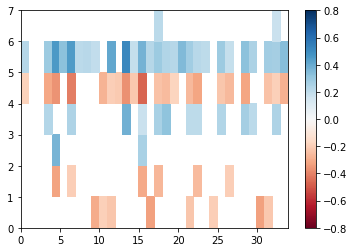

In [46]:
cbar = plt.pcolormesh(varstack_sig, vmin=-0.8, vmax=0.8, cmap='RdBu')
plt.colorbar(cbar)